In [1]:
# ---------------------- IMPORTS ----------------------
import os
from os.path import basename
if basename(os.getcwd()) == 'util':
    os.chdir("../")
import config.model
if basename(os.getcwd()) == 'experiment-framework':
    os.chdir("util/")
import numpy as np
import torch
import pickle
import copy
from collections import OrderedDict
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import torch.utils.data as utils
import torch.nn.functional as F

from activation_plot_code import plot_combination_acts
from activation_plot_code import plot_act_matrix
from activation_plot_code import plot_accuracy_table
from activation_plot_code import update_acts_dicts
from activation_plot_code import get_acts_matrix
from activation_plot_code import get_accuracy_ablation
from activation_plot_code import get_med_and_std

# SELECTIVITY
#(max - avg)/(max + avg)
from activation_plot_code import get_selectivity_array 

#(max - 2nd_max)/(max + 2nd_max)
from activation_plot_code import get_selectivity_array2

#choose task1/task2. max determines which of the num_classes
#    tasks to take min from. elt1 = min. elt2 = max of any combo not in
#    the class being focused on
from activation_plot_code import get_selectivity_array3

#Like get_selectivity_array3, but for specific class
from activation_plot_code import get_selectivity_task





In [2]:
# ----------------- ENTER INFO -----------------
#dataset names to choose from: 
#    "left_out_varied_location_mnist", "left_out_colored_mnist"

#layer name to choose from: 
#    "", "_layer1", "_layer3"

#model names to choose from:
#    "simple_cnn", "resnet", "resnet_no_pool", "resnet_pretrained",
#    "resnet_pretrained_embeddings"


dataset_name = "left_out_colored_mnist"
layer = "" 
model_name = "simple_cnn"
show_violin_plot_median = True
show_violin_plot_mean = False
show_violin_plot_extrema = True

#Which of the 512 units are displayed in the individual and
#    std/mean/divide plots
individual_neuron_plots_start_index = 5
individual_neuron_plots_end_index = 12

#for activation plots. How many clusters
num_clusters = 20


#can change keep_pct to get activation plots for different % seen combos

#for left_out_colored_mnist, choices are:
#    .1,.2,.3,.4,.5,.6,.7,.8,.9
if dataset_name == "left_out_colored_mnist":
    keep_pct = 0.9

#for left_out_varied_location_mnist, choices are:
#    0.1111111111111111,0.2222222222222222,0.3333333333333333,
#    0.4444444444444444,0.5555555555555556,0.6666666666666666,
#    0.7777777777777778,0.8888888888888888
elif dataset_name == "left_out_varied_location_mnist":
    keep_pct = 0.8888888888888888


In [3]:
# ----------------- LOAD DATA -----------------
if dataset_name == "left_out_colored_mnist":
    num_classes = 10
elif dataset_name == "left_out_varied_location_mnist":
    num_classes = 9
    
data_type = ""
file_path = "../analysis/"+model_name+"/"
filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name + layer, int(100*keep_pct), data_type)
with open(file_path + filename,'rb') as f:
    activations_dict = pickle.load(f)

In [4]:
# ---------- POPULATE MATRICES/DICTS FOR PLOTTING ----------
combinations = [k for k in activations_dict]

sort_by_task2 = False
if sort_by_task2:
    combinations.sort(key = lambda x: (x[1],x[0]))
else:
    combinations.sort()

task1_classes = [k for k in range(num_classes)]
task2_classes = [k for k in range(num_classes)]

num_neurons = activations_dict[[k for k in activations_dict][0]].shape[1]
neuron_combinations_mat = np.zeros((num_neurons, num_classes, num_classes))
acts_mat = np.zeros((len(combinations),num_neurons))
avg_acts_dict = {}
task1_acts_dict = {}
task2_acts_dict = {}

for idx,k in enumerate(combinations):
    avg_acts_dict[k] = np.mean(activations_dict[k],axis=0)
    neuron_combinations_mat[:,k[0],k[1]] = copy.deepcopy(avg_acts_dict[k]) 
    acts_mat[idx] = copy.deepcopy(avg_acts_dict[k])
 
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_acts_mat = acts_mat / np.max(acts_mat,axis=0)
    normalized_acts_mat = normalized_acts_mat[:,~np.isnan(normalized_acts_mat).any(axis=0)]



<br><b>Individual Neuron Activation Plots</b> $x$-axis: Digit classification, $y$-axis: Color classification

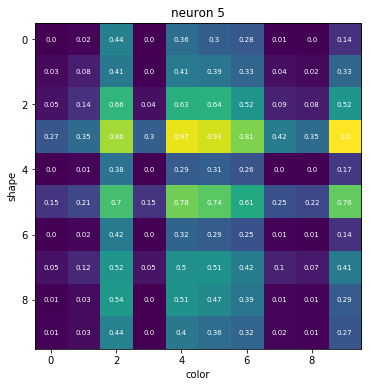

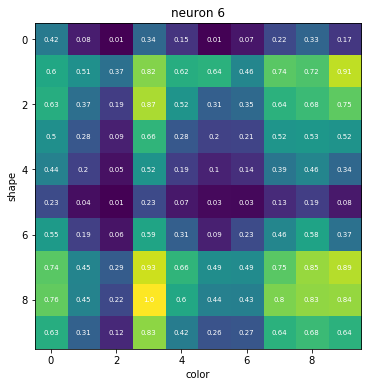

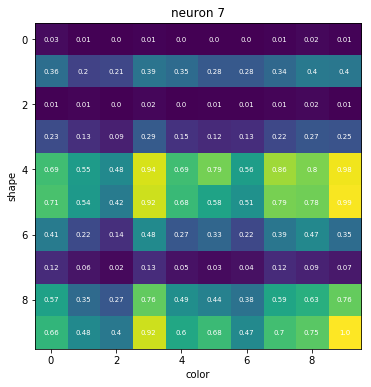

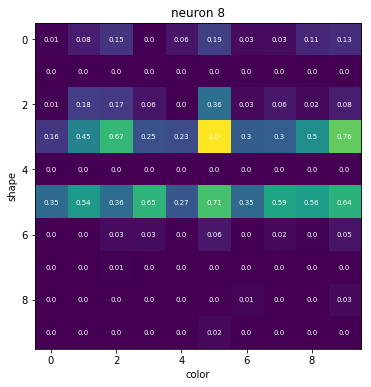

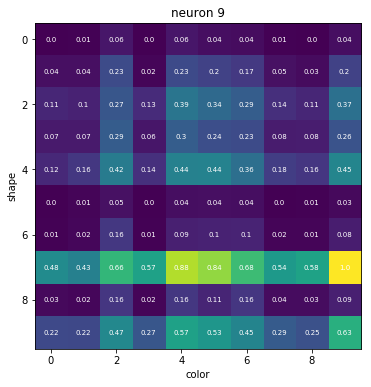

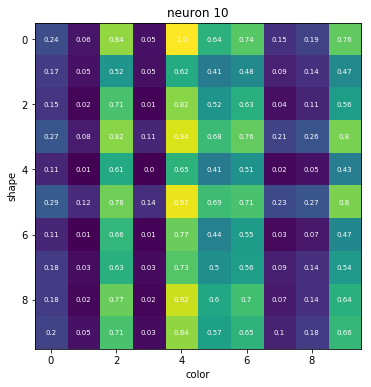

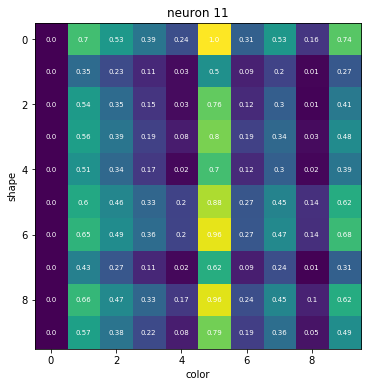

In [5]:
plot_combination_acts(neuron_combinations_mat,
                      individual_neuron_plots_start_index,
                      individual_neuron_plots_end_index,
                      normalize="individual",
                      num_classes=num_classes,
                      plot_single_column=True,
                      plot_size=6,
                      dataset_name=dataset_name)





<br><b>Full Activation Plot</b> $y$-axis: target (digit,color), $x$-axis: neuron/cluster

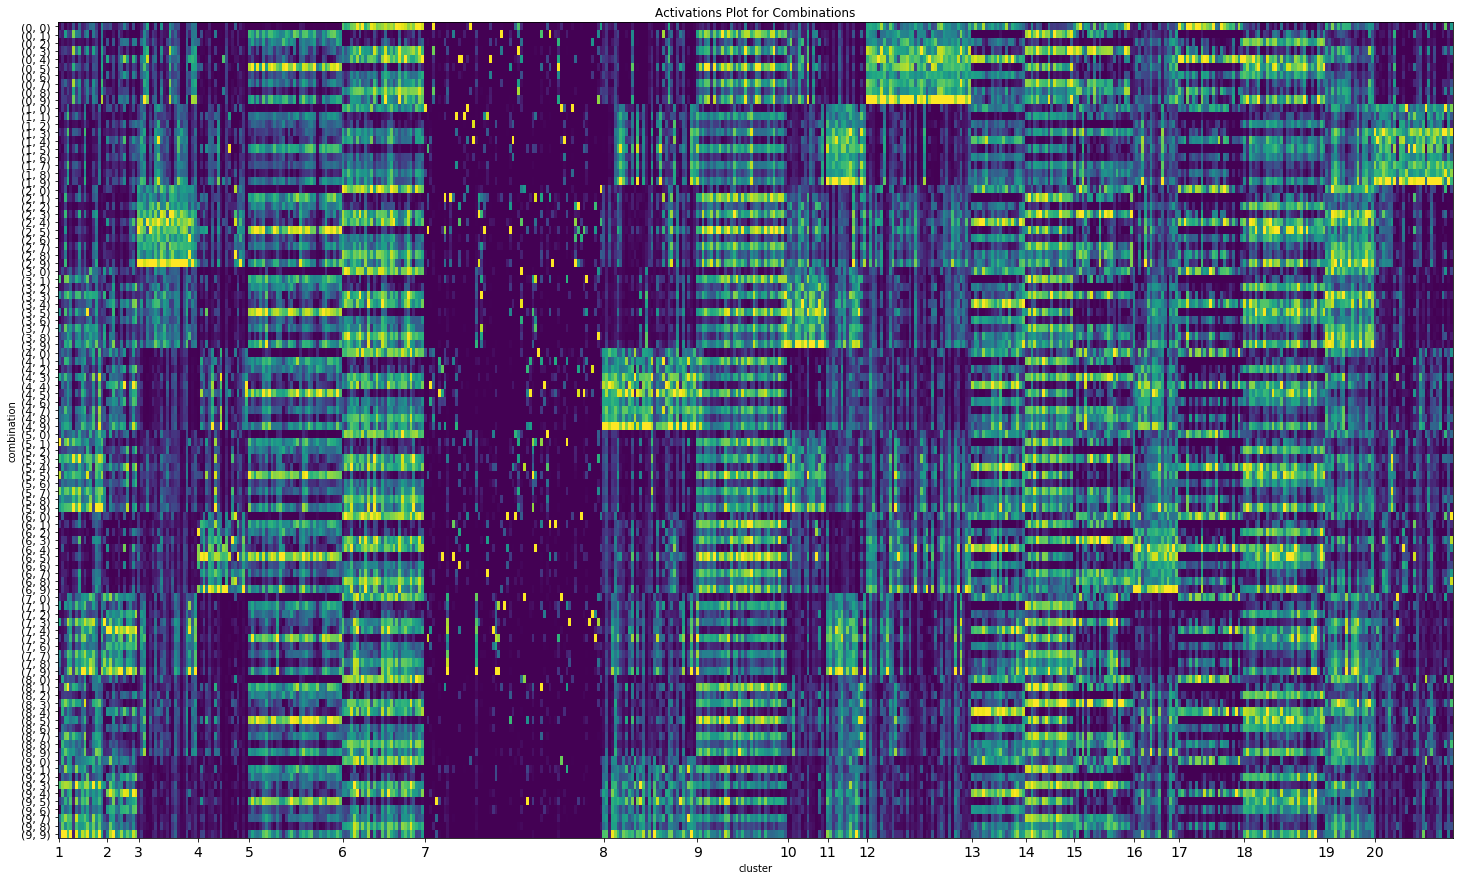

In [6]:
plot_act_matrix(act_matrix=normalized_acts_mat, combinations_list=combinations,
                n_clusters=num_clusters)



In [7]:
# ----------- LOAD DATA FOR SELECTIVITY PLOTS --------------
if dataset_name == "left_out_colored_mnist":
    num_classes = 10
    keep_pct_values = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
else:
    num_classes = 9
    keep_pct_values = [.11,.22,.33,.44,.55,.66,.77,.88]

holdout_acts_dict = {}

for keep_pct in keep_pct_values:
    file_path = "../analysis/"+model_name+"/"
    filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name + layer, int(100*keep_pct), data_type)
    with open(file_path + filename,'rb') as f:
        holdout_acts_dict[int(100*keep_pct)] = pickle.load(f)

        

In [8]:

num_neurons = holdout_acts_dict[int(100*keep_pct_values[0])][combinations[0]].shape[1]

combo_acts_dict = {}
task1_acts_dict = {}
task2_acts_dict = {}

#(Max-Second_max)/(Max+Second_max)
selectivity2_combos = {}

#(Min_in_class - Max_elsewhere)/(Min_in_class + Max_elsewhere)
selectivity3_task1 = {}
selectivity3_task2 = {}

#For calculating top n selective neurons per class later
#Uses same as selectivity3 but in plot function you can specify task_idx AND class
selectivity_task1 = []
selectivity_task2 = []
for i in range(num_classes):
    selectivity_task1.append({})
    selectivity_task2.append({})



for keep_pct in keep_pct_values:
    keep_pct = int(100 * keep_pct)

    combo_acts_dict[keep_pct] = {}
    task1_acts_dict[keep_pct] = {}
    task2_acts_dict[keep_pct] = {}
    
    update_acts_dicts(combinations[:], holdout_acts_dict[keep_pct],
                      combo_acts_dict[keep_pct], task1_acts_dict[keep_pct],
                      task2_acts_dict[keep_pct], num_neurons=num_neurons)
    
    
    selectivity2_combos[keep_pct] = get_selectivity_array2(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons)
    selectivity3_task1[keep_pct] = get_selectivity_array3(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=0)
    selectivity3_task2[keep_pct] = get_selectivity_array3(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=1)
    
    for i in range(num_classes):
        selectivity_task1[i][keep_pct] =  get_selectivity_task(combo_acts_dict[keep_pct], combinations[:], class_num=i, task_idx=0, num_neurons=num_neurons)
        selectivity_task2[i][keep_pct] =  get_selectivity_task(combo_acts_dict[keep_pct], combinations[:], class_num=i, task_idx=1, num_neurons=num_neurons)
    


<br><b>Selectivity Plots</b>

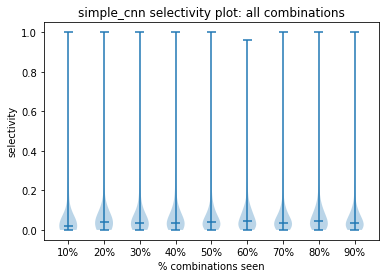

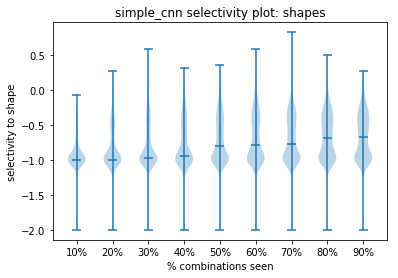

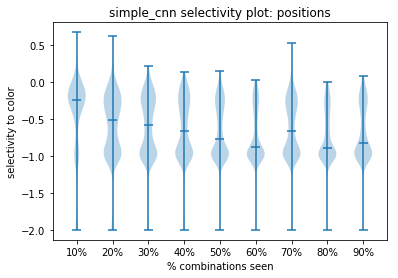

In [9]:
import matplotlib
from matplotlib import pyplot as plt
select1 = selectivity2_combos
select2 = selectivity3_task1
select3 = selectivity3_task2

x = [str(int(100*kpt)) for kpt in keep_pct_values]
y1 = [get_med_and_std(select1[int(100*kpt)])[0] for kpt in keep_pct_values]
y1err = [get_med_and_std(select1[int(100*kpt)])[1] for kpt in keep_pct_values]
y1_violin = [select1[int(100*kpt)] for kpt in keep_pct_values]

y2 = [get_med_and_std(select2[int(100*kpt)])[0] for kpt in keep_pct_values]
y2err = [get_med_and_std(select2[int(100*kpt)])[1] for kpt in keep_pct_values]
y2_violin = [select2[int(100*kpt)] for kpt in keep_pct_values]

y3 = [get_med_and_std(select3[int(100*kpt)])[0] for kpt in keep_pct_values]
y3err = [get_med_and_std(select3[int(100*kpt)])[1] for kpt in keep_pct_values]
y3_violin = [select3[int(100*kpt)] for kpt in keep_pct_values]

xlabs = [str(int(100*kpt)) + '%' for kpt in keep_pct_values]
showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema


#print(y1_violin)
#plt.figure()
fig, ax = plt.subplots()
plt.xlabel("% combinations seen")
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
#plt.xticks([r+1 for r in range(len(keep_pct_values))],xlabs)
plt.ylabel("selectivity")
plt.title(model_name + " selectivity plot: all combinations")
#plt.errorbar(x, y1, yerr=y1err)
plt.violinplot(y1_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()

#plt.figure()
fig, ax = plt.subplots()
plt.xlabel("% combinations seen")
#plt.xticks([r+1 for r in range(len(keep_pct_values))],xlabs)
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
plt.ylabel("selectivity to shape")
plt.title(model_name + " selectivity plot: shapes")
#plt.errorbar(x, y2, yerr=y2err)
plt.violinplot(y2_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()

#plt.figure()
fig, ax = plt.subplots()
plt.xlabel("% combinations seen")
#plt.xticks([r+1 for r in range(len(keep_pct_values))],xlabs)
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
plt.ylabel("selectivity to color")
plt.title(model_name + " selectivity plot: positions")
#plt.errorbar(x, y3, yerr=y3err)
plt.violinplot(y3_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()



In [10]:
run_eval = False

In [11]:
if basename(os.getcwd()) == 'experiment-framework':
    os.chdir("util/")
classes = [n for n in range(num_classes)]

if dataset_name == "left_out_varied_location_mnist":
    keep = 88
    keep_pct = '0.8888888888888888'
    num_classes = 9
else:
    keep = 90
    keep_pct = '0.9'
    num_classes = 10
    
early_stop=10000

columns = [str(n) for n in range(num_classes)]
rows = [str(n) for n in range(num_classes)]
data1 = np.zeros((num_classes,num_classes))
data2 = np.zeros((num_classes,num_classes))
data3 = np.zeros((num_classes,num_classes))
data4 = np.zeros((num_classes,num_classes))
data5 = np.zeros((num_classes,num_classes))
data6 = np.zeros((num_classes,num_classes))

n = 100 #NUMBER OF NEURONS TO ABLATE

if model_name != "simple_cnn":
    to_ablate_rnd = np.random.random_integers(0,511,100)
else:
    to_ablate_rnd = np.random.random_integers(0,499,100)

run = "all"

#Task1
if run_eval and (run == "task1" or run == "all"):
    for c1 in range(num_classes):

        ordered_neurons = np.argsort(selectivity_task1[c1][keep])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        ablated = ordered_neurons[:n]

        print(c1, ablated[:5])

        for c2 in range(num_classes):
            
            targets = [(c2,k) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False)
            data1[c1][c2] = acc1
            
            targets = [(k,c2) for k in range(num_classes)]  
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False)
            data2[c1][c2] = acc2
            print('---')
            
    d1 = data1
    d2 = data2
    
#task2
if run_eval and (run == "task2" or run == "all"):
    for c1 in range(num_classes):

        ordered_neurons = np.argsort(selectivity_task2[c1][keep])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        ablated = ordered_neurons[:n]

        print(c1)

        for c2 in range(num_classes):
            targets = [(c2,k) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False)
            data3[c1][c2] = acc1
            
            targets = [(k,c2) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False)
            data4[c1][c2] = acc2
            print('---')

    d3 = data3
    d4 = data4
    
if run_eval and (run == "random" or run == "all"):
    for c1 in range(num_classes):

        ablated = to_ablate_rnd

        print(c1)

        for c2 in range(num_classes):
            targets = [(c2,k) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False)
            data5[c1][c2] = acc1
            
            targets = [(k,c2) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False)
            data6[c1][c2] = acc2
            print('---')

    d5 = data5
    d6 = data6
    




    


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: This function is deprecated. Please call randint(0, 499 + 1) instead


In [12]:
if run_eval:
    print("Ablation of 100 shape selective neurons: Accuracy for shape classes")
    plot_accuracy_table(d1,num_classes=num_classes)

    print("\n\nAblation of 100 shape selective neurons: Accuracy for color classes")
    plot_accuracy_table(d2,num_classes=num_classes)

    print("Ablation of 100 color selective neurons: Accuracy for shape classes")
    plot_accuracy_table(d3,num_classes=num_classes)

    print("\n\nAblation of 100 color selective neurons: Accuracy for color classes")
    plot_accuracy_table(d4,num_classes=num_classes)



In [13]:
if run_eval:
    name = model_name + '_{}_ablation_{}.npy'
    if dataset_name == "left_out_varied_location_mnist":
        name = model_name + '_{}_ablation_{}_location.npy'
    name = name.format
    name_d1 = name("shape","shape")
    name_d2 = name("shape","color")
    name_d3 = name("color","shape")
    name_d4 = name("color","color")
    name_d5 = name("random","shape")
    name_d6 = name("random","color")


    np.save(name_d1,d1)
    np.save(name_d2,d2)
    np.save(name_d3,d3)
    np.save(name_d4,d4)
    np.save(name_d5,d5)
    np.save(name_d6,d6)


<br><b>Ablation Plots</b>

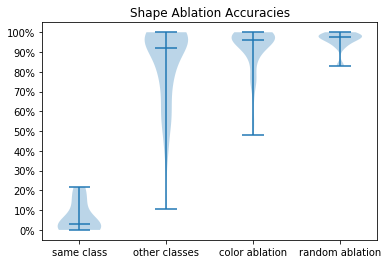

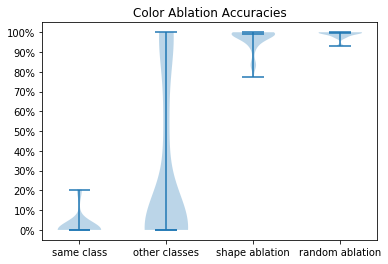

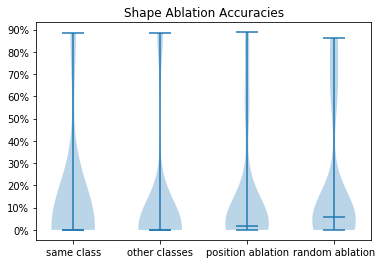

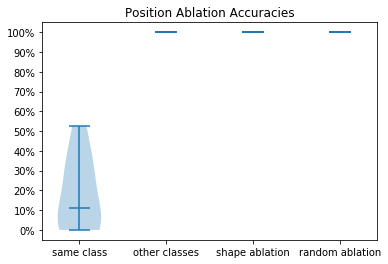

In [14]:

file = "../analysis/" + model_name +"/"+ model_name +"_{}_ablation_{}.npy"
file2 = "../analysis/"+ model_name +"/"+ model_name +"_{}_ablation_{}_location.npy"
file = file.format
file2 = file2.format

d1 = np.load(file("shape","shape"))
d2 = np.load(file("shape","color"))
d3 = np.load(file("color","shape"))
d4 = np.load(file("color","color"))
d5 = np.load(file("random","shape"))
d6 = np.load(file("random","color"))

d1_loc = np.load(file2("shape","shape"))
d2_loc = np.load(file2("shape","color"))
d3_loc = np.load(file2("color","shape"))
d4_loc = np.load(file2("color","color"))
d5_loc = np.load(file2("random","shape"))
d6_loc = np.load(file2("random","color"))

showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema

#accuracy of ablated class 
shape_diagonal_vals = np.diagonal(d1)
color_diagonal_vals = np.diagonal(d4)
loc_diagonal_vals = np.diagonal(d1_loc)
cloc_diagonal_vals = np.diagonal(d4_loc)

#accuracy of non-ablated class
shape_nondiagonal_vals = d1[np.identity(10)==0]
color_nondiagonal_vals = d4[np.identity(10)==0]
loc_nondiagonal_vals = d1_loc[np.identity(9)==0]
cloc_nondiagonal_vals = d4_loc[np.identity(9)==0]

#accuracy with ablated from different attribute
shape_ablate_color_vals = d3
color_ablate_shape_vals = d2
loc_ablate_color_vals = d3_loc
cloc_ablate_loc_vals = d2_loc

#Ablate random 100 - accuracy
shape_ablate_random_vals = d5
color_ablate_random_vals = d6
loc_ablate_random_vals = d5_loc
cloc_ablate_random_vals = d6_loc

yticklabels =[str(r) + '%' for r in range(0,110,10)]

shape_violin = [shape_diagonal_vals,shape_nondiagonal_vals,shape_ablate_color_vals,shape_ablate_random_vals]
fig, ax = plt.subplots()
ax.set_title("Shape Ablation Accuracies")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['same class','other classes', 'color ablation', 'random ablation'])
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax.set_yticklabels(yticklabels)
plt.violinplot(shape_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()

color_violin = [color_diagonal_vals,color_nondiagonal_vals,color_ablate_shape_vals,color_ablate_random_vals]
fig, ax = plt.subplots()
ax.set_title("Color Ablation Accuracies")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['same class','other classes', 'shape ablation', 'random ablation'])
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax.set_yticklabels(yticklabels)
plt.violinplot(color_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()


shape_violin = [loc_diagonal_vals,loc_nondiagonal_vals,loc_ablate_color_vals,loc_ablate_random_vals]
fig, ax = plt.subplots()
ax.set_title("Shape Ablation Accuracies")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['same class','other classes', 'position ablation', 'random ablation'])
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax.set_yticklabels(yticklabels)
plt.violinplot(shape_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()

color_violin = [cloc_diagonal_vals,cloc_nondiagonal_vals,cloc_ablate_loc_vals,cloc_ablate_random_vals]
fig, ax = plt.subplots()
ax.set_title("Position Ablation Accuracies")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['same class','other classes', 'shape ablation', 'random ablation'])
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax.set_yticklabels(yticklabels)
plt.violinplot(color_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()





(2, 10, 10, 10, 32, 32, 3)


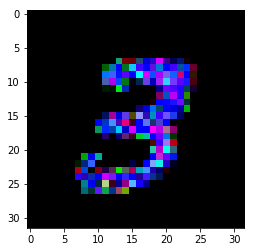

In [15]:
'''
file = '../analysis/invariance_data.npy'
data = np.load(file)
print(data.shape)
t = 0
task1 = 4
trial = 0
task2 = 0

plt.imshow(data[t][task1][trial][task2])
plt.show()
'''
file = '../analysis/invariance_data_w_color_noise.npy'
data = np.load(file)
print(data.shape)
t = 1
task1 = 2
trial = 0
task2 = 3

plt.imshow(data[t][task1][trial][task2])
plt.show()


In [16]:
noise = True
keep = 90
#model_name = 'resnet'
#model_name = 'resnet_pretrained_embeddings'
#model_name = 'resnet_no_pool'
#model_name = 'simple_cnn'
if not noise:
    file = '../analysis/processed_array' + str(keep) + '.npy'
else:
    file = '../analysis/' + model_name + "_processed_array" + '_noise' + str(keep) + '.npy'
#file = '../analysis/processed_array20.npy'
#(2, 10, N, 10 32,32,3)
#type, shape class, num_examples, color class, RGB img
data = np.load(file)
print(data.shape)


(2, 10, 10, 10, 500)


(2, 10, 500)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


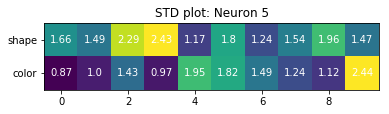

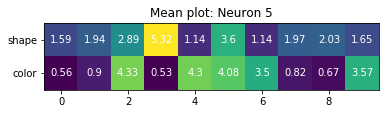

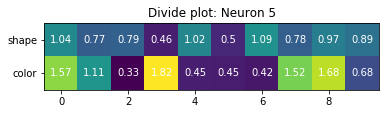

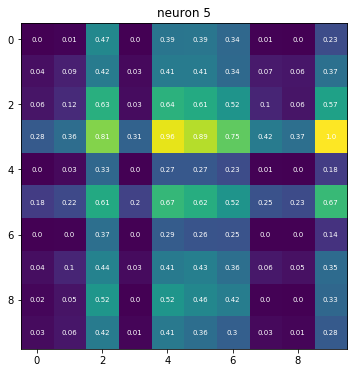

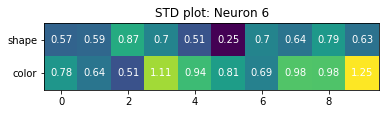

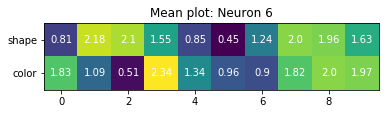

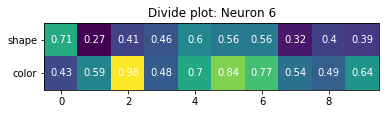

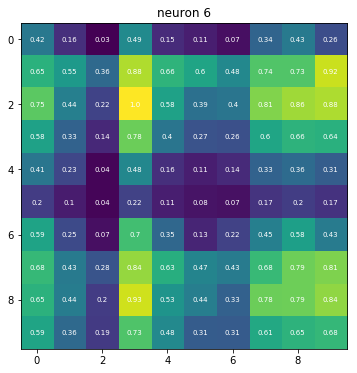

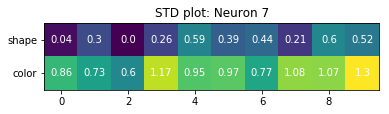

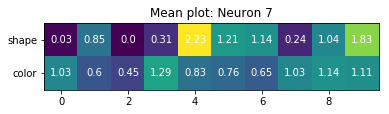

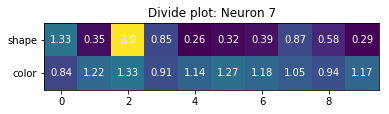

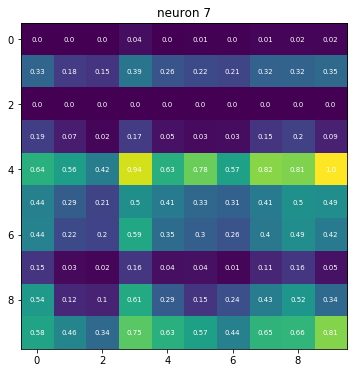

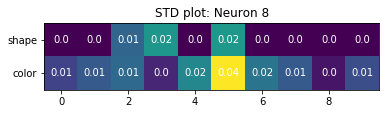

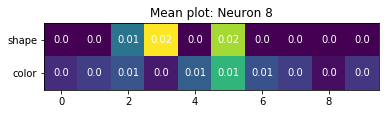

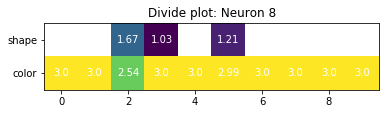

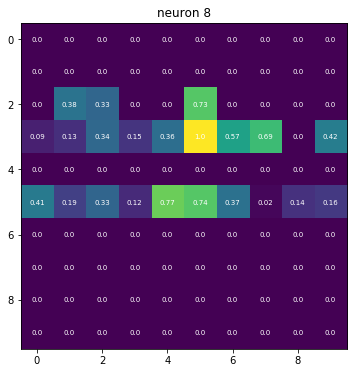

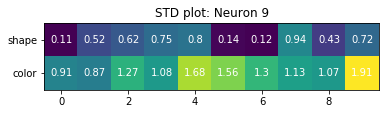

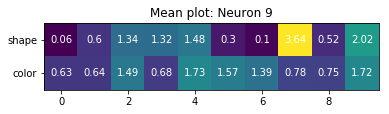

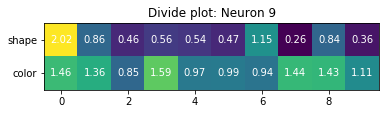

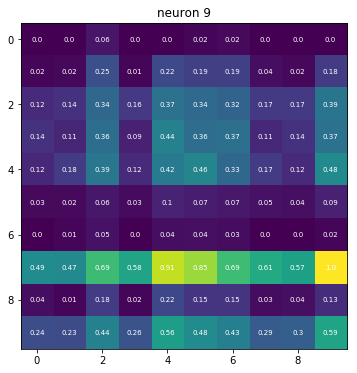

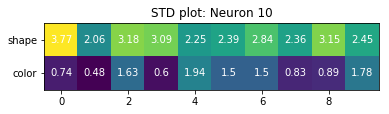

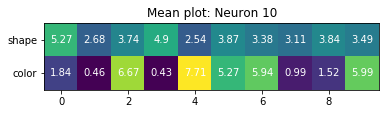

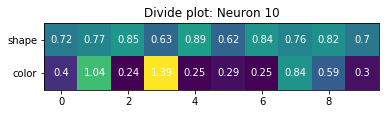

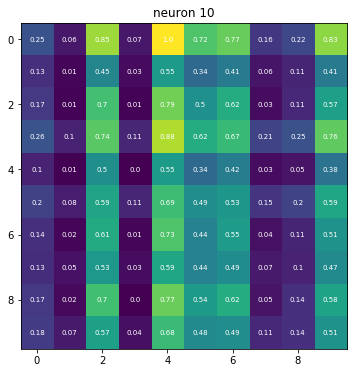

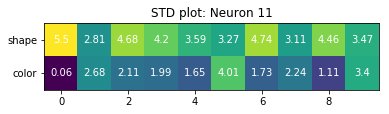

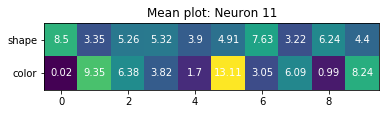

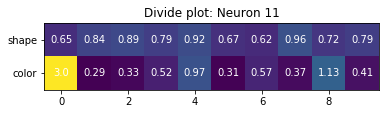

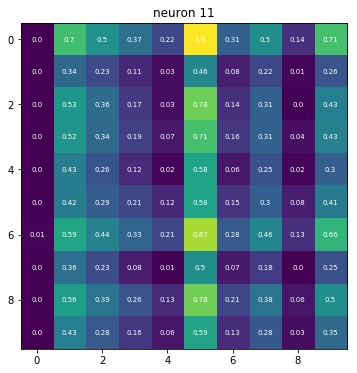

In [17]:
tables_mean = np.mean(data, axis=3)
tables_mean = np.mean(tables_mean, axis=2)
print(tables_mean.shape)
if model_name == 'simple_cnn':
    num_neurons = 500
else:
    num_neurons = 512

tables_std = np.std(data, axis=3)
tables_std = np.mean(tables_std, axis=2)

tables_divide = np.divide(tables_std, tables_mean)
#tables_divide[tables_divide == np.inf] = 0

data_mean = np.mean(data, axis=2)
neuron_combinations_mat0 = np.zeros((num_neurons, num_classes, num_classes))
neuron_combinations_mat1 = np.zeros((num_neurons, num_classes, num_classes))
for i in range(10):
    for j in range(10):
        neuron_combinations_mat0[:,i,j] = copy.deepcopy(data_mean[0][i][j])
        neuron_combinations_mat1[:,i,j] = copy.deepcopy(data_mean[1][i][j])
        
neuron_range = [individual_neuron_plots_start_index,individual_neuron_plots_end_index]


for i in range(neuron_range[0], neuron_range[1]):
    #print(tables[:,:,i])
    
    
    fig, ax = plt.subplots()
    plt.title("STD plot: Neuron " + str(i))
     
    for j in range(2):
        for k in range(10):
            out = round(tables_std[:,:,i][j][k],2)
            if out > 1:
                out = round(out,2)
            text = ax.text(k,j, out, color='w', size=10,
                          ha = 'center', va='center')
            
    plt.imshow(tables_std[:,:,i])
    plt.yticks([0,1],['shape','color'])
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Mean plot: Neuron " + str(i))
    
    for j in range(2):
        for k in range(10):
            out = round(tables_mean[:,:,i][j][k],2)
            if out > 1:
                out = round(out,2)
            text = ax.text(k,j, out, color='w', size=10,
                           ha = 'center', va='center')
            
    plt.imshow(tables_mean[:,:,i])
    plt.yticks([0,1],['shape','color'])
    plt.show()
    
    
    fig, ax = plt.subplots()
    plt.title("Divide plot: Neuron " + str(i))
    
    for j in range(2):
        for k in range(10):
            out = round(tables_divide[:,:,i][j][k],2)
            if out > 1:
                out = round(out,2)
            text = ax.text(k,j, out, color='w', size=10,
                          ha = 'center', va='center')
    
    
    plt.imshow(tables_divide[:,:,i])
    plt.yticks([0,1],['shape','color'])
    plt.show()
    
    
    
    plot_combination_acts(neuron_combinations_mat0, i,i+1)
    #plot_combination_acts(neuron_combinations_mat1, i)

    
    
    


(2, 10, 500)
SHAPE


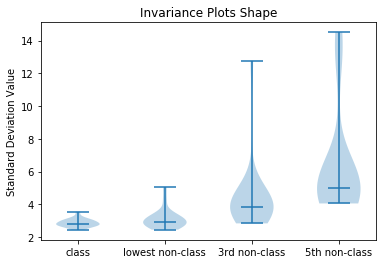



COLOR---------------------------------------------


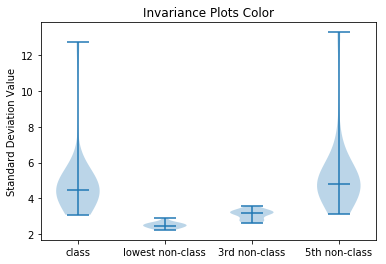

In [18]:
print(tables_divide.shape)
invariance1 = []
invariance2 = []
n = 20
table = copy.deepcopy(tables_divide)
table[np.isnan(table)] = 10

showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema

def get_nth_smallest(array, leave_out, n_list, first_idx=0, place=0):
    par_list = []
    for i in range(10):
        if i in leave_out:
            continue
        par_list.append(array[first_idx,i,n_list])
    par_list = np.array(par_list)
    return np.partition(par_list,place,axis=0)[place]
    
    

for c1 in range(10):
    first_index = 0
    ordered_neurons = np.argsort(selectivity_task1[c1][keep])
    ordered_neurons = np.flip(ordered_neurons, axis=0)
    neurons_array = ordered_neurons[:n]
    class_inv = copy.deepcopy(table[first_index,c1,neurons_array])
    second_inv = get_nth_smallest(copy.deepcopy(table), [c1], neurons_array)
    third_inv = get_nth_smallest(copy.deepcopy(table), [c1], neurons_array, place=2)
    fifth_inv = get_nth_smallest(copy.deepcopy(table), [c1], neurons_array, place=4)
    #invariance1 += [class_inv,second_inv,third_inv,fifth_inv]
    if len(invariance1) == 0:
        invariance1 = [class_inv,second_inv,third_inv,fifth_inv]
    else:
        invariance1[0] += class_inv
        invariance1[1] += second_inv
        invariance1[2] += third_inv
        invariance1[3] += fifth_inv
#invariance1 = np.reshape(invariance1,(-1,4))
    
for c2 in range(10):
    first_index = 1
    ordered_neurons = np.argsort(selectivity_task2[c2][keep])
    ordered_neurons = np.flip(ordered_neurons, axis=0)
    neurons_array = ordered_neurons[:n]
    class_inv = copy.deepcopy(table[first_index,c1,neurons_array])
    second_inv = get_nth_smallest(copy.deepcopy(table), [c2], neurons_array, first_idx=first_index)
    third_inv = get_nth_smallest(copy.deepcopy(table), [c2], neurons_array, first_idx=first_index, place=2)
    fifth_inv = get_nth_smallest(copy.deepcopy(table), [c2], neurons_array, first_idx=first_index, place=4)
    #invariance2 += [class_inv,second_inv,third_inv,fifth_inv]
    if len(invariance2) == 0:
        invariance2 = [class_inv,second_inv,third_inv,fifth_inv]
    else:
        invariance2[0] += class_inv
        invariance2[1] += second_inv
        invariance2[2] += third_inv
        invariance2[3] += fifth_inv

print("SHAPE")
#for i in range(10):
fig, ax = plt.subplots()
ax.set_title("Invariance Plots Shape")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['class','lowest non-class', '3rd non-class', '5th non-class'])
ax.set_ylabel("Standard Deviation Value")
plt.violinplot(invariance1, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()
    
print("\n\nCOLOR---------------------------------------------")
#for j in range(10):
fig, ax = plt.subplots()
ax.set_title("Invariance Plots Color")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['class','lowest non-class', '3rd non-class', '5th non-class'])
ax.set_ylabel("Standard Deviation Value")
plt.violinplot(invariance2, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()

    
    